##### Copyright 2019 The TensorFlow Hub Authors.

Apache License, Version 2.0（以下「ライセンス」）によるライセンス契約;

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                  # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 映画レビューを使ったテキスト分類

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_text_classification">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/hub/tutorials/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/hub/tutorials/tf2_text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
  <td><a href="https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub モデルを見る</a></td>
</table>

このノートブックでは、映画レビューのテキストを使用して、それが*肯定的*であるか*否定的*であるかに分類します。これは*二項*分類の例で、機械学習問題では重要な分類法として広く適用されます。

[Internet Movie Database](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) より、50,000 件の映画レビューテキストが含まれる [IMDB データセット](https://www.imdb.com/)を使用します。これは、トレーニング用の 25,000 件のレビューとテスト用の 25,000 件のレビューに分割されます。トレーニングセットとテストセットは*均衡が保たれており*、肯定的評価と否定的評価が同じ割合で含まれます。

このノートブックでは、TensorFlow でモデルを構築してトレーニングするための [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) という高レベル API と、転移学習用のライブラリ兼プラットフォームである [TensorFlow Hub](https://www.tensorflow.org/hub) を使用します。`tf.keras` を使用した、より高度なテキスト分類チュートリアルについては、[MLCC Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification/) をご覧ください。

### その他のモデル

テキスト埋め込みの生成に使用できる、より表現豊かなモデルや効率性の高いモデルを[こちら](https://tfhub.dev/s?module-type=text-embedding)でご覧ください。

## MNIST モデルをビルドする

In [3]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2024-01-11 19:52:40.814991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:52:40.815032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:52:40.816571: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Version:  2.15.0
Eager mode:  True
Hub version:  0.15.0
GPU is available


## IMDB データセットをダウンロードする

IMDB データセットは、[TensorFlow データセット](https://github.com/tensorflow/datasets)で提供されています。次のコードを使って、IMDB データセットをマシン（または Colab ランタイム）にダウンロードしてください。

In [4]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

## データの観察

データの形式を確認してみましょう。各サンプルは、映画レビューを表す文章と対応するラベルです。文章はまったく事前処理されていません。ラベルは 0 または 1 の整数値で、0 は否定的なレビューで 1 は肯定的なレビューを示します。

In [5]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


最初の 10 個のサンプルを出力しましょう。

In [6]:
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

最初の 10 個のラベルも出力しましょう。

In [7]:
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

## モデルを構築する

ニューラルネットワークは、レイヤーのスタックによって作成されています。これには、次の 3 つのアーキテクチャ上の決定が必要です。

- どのようにテキストを表現するか。
- モデルにはいくつのレイヤーを使用するか。
- 各レイヤーにはいくつの*非表示ユニット*を使用するか。

この例では、入力データは文章で構成されています。予測するラベルは、0 または 1 です。

テキストの表現方法としては、文章を埋め込みベクトルに変換する方法があります。トレーニング済みのテキスト埋め込みを最初のレイヤーとして使用することで、次のような 2 つのメリットを得ることができます。

- テキストの事前処理を心配する必要がない。
- 転移学習を利用できる。

この例では、[TensorFlow Hub](https://www.tensorflow.org/hub) のモデルである「[google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2)」を使います。

このチュートリアルのためにテストできるモデルが、ほかに 2 つあります。

- [google/nnlm-en-dim50-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2) - [google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2) と同じものですが、句読点を削除するためのテキスト正規化が含まれています。このため、入力テキストのトークンに使用する語彙内埋め込みのカバレッジを改善することができます。
- [google/nnlm-en-dim128-with-normalization/2](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) - 50 次元未満でなく、128 の埋め込み次元を備えたより大規模なモデルです。

では始めに、TensorFlow Hub モデル を使用して文章を埋め込む Keras レイヤーを作成し、いくつかの入力サンプルで試してみましょう。生成される埋め込みの出力形状は、`(num_examples, embedding_dimension)` であるところに注意してください。

In [8]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423194 , -0.01190171,  0.06337537,  0.0686297 , -0.16776839,
        -0.10581177,  0.168653  , -0.04998823, -0.31148052,  0.07910344,
         0.15442258,  0.01488661,  0.03930155,  0.19772716, -0.12215477,
        -0.04120982, -0.27041087, -0.21922147,  0.26517656, -0.80739075,
         0.25833526, -0.31004202,  0.2868321 ,  0.19433866, -0.29036498,
         0.0386285 , -0.78444123, -0.04793238,  0.41102988, -0.36388886,
        -0.58034706,  0.30269453,  0.36308962, -0.15227163, -0.4439151 ,
         0.19462997,  0.19528405,  0.05666233,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201319 , -0.04418665, -0.08550781,
        -0.55847436, -0.2333639 , -0.20782956, -0.03543065, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862677,  0.7753425 , -0.07667087,
        -0.15752274,  0.01872334, -0.08169781, -0.3521876 ,  0.46373403,
        -0.08492758,  0.07166861, -0.00670818,  0.12686071, -0.19326551,
 

今度は、完全なモデルを構築しましょう。

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 50)                48190600  


 dense (Dense)               (None, 16)                816       


 dense_1 (Dense)             (None, 1)                 17        


Total params: 48191433 (183.84 MB)


Trainable params: 48191433 (183.84 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


これらのレイヤーは、分類器を構成するため一列に積み重ねられます。

1. 最初のレイヤーは、TensorFlow Hub レイヤーです。このレイヤーは文章から埋め込みベクトルにマッピングする事前トレーニング済みの SavedModel を使用します。使用しているモデル ([google/nnlm-en-dim50/2](https://tfhub.dev/google/nnlm-en-dim50/2)) は文章とトークンに分割し、各トークンを埋め込んで、埋め込みを組み合わせます。その結果、次元は `(num_examples, embedding_dimension)` となります。
2. この固定長の出力ベクトルは、16 個の非表示ユニットを持つ全結合（`Dense`）レイヤーに受け渡されます。
3. 最後のレイヤーは単一の出力ノードで密に接続されます。これは、ロジットを出力します。モデルに応じた、真のクラスの対数オッズです。

### 非表示ユニット

上記のモデルには、入力と出力の間に 2 つの中間または「非表示」レイヤーがあります。出力数（ユニット数、ノード数、またはニューロン数）はレイヤーの表現空間の次元で、言い換えると、内部表現を学習する際にネットワークが許可された自由の量と言えます。

モデルの非表示ユニット数やレイヤー数が増えるほど（より高次元の表現空間）、ネットワークはより複雑な表現を学習できますが、ネットワークの計算がより高価となり、トレーニングデータでのパフォーマンスを改善してもテストデータでのパフォーマンスは改善されない不要なパターンが学習されることになります。この現象を*過適合*と呼び、これについては後の方で説明します。

### 損失関数とオプティマイザ

モデルをトレーニングするには、損失関数とオプティマイザが必要です。これは二項分類問題であり、モデルは確率（シグモイドアクティベーションを持つ単一ユニットレイヤー）を出力するため、`binary_crossentropy` 損失関数を使用します。

これは、損失関数の唯一の選択肢ではありません。たとえば、`mean_squared_error` を使用することもできます。ただし、一般的には、確率を扱うには `binary_crossentropy` の方が適しているといえます。これは、確率分布間、またはこのケースではグランドトゥルース分布と予測間の「距離」を測定するためです。

後の方で、回帰問題（家の価格を予測するなど）を考察する際に、平均二乗誤差と呼ばれる別の損失関数の使用方法を確認します。

では、オプティマイザと損失関数を使用するようにモデルを構成します。

In [10]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

## 検証セットを作成する

トレーニングの際、モデルが遭遇したことのないデータでモデルの精度を確認したいと思います。そこで、元のトレーニングデータから 10,000 個のサンプルを取り出して*検証セット*を作成します（ここでテストセットを使用しないのは、トレーニングデータのみを使用してモデルの構築と調整を行った上で、テストデータを一度だけ使用して精度を評価することを目標としているからです）。

In [11]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## モデルのトレーニング

モデルを 512 サンプルのミニバッチで 40 エポック、トレーニングします。これは、`x_train` と `y_train` テンソルのすべてのサンプルを 40 回イテレーションします。トレーニング中、検証セットの 10,000 個のサンプルで、モデルの損失と精度を監視します。

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40


I0000 00:00:1705002774.562487  131311 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/30 [>.............................] - ETA: 53s - loss: 0.7336 - accuracy: 0.4941

 2/30 [=>............................] - ETA: 5s - loss: 0.7235 - accuracy: 0.4941 

 3/30 [==>...........................] - ETA: 5s - loss: 0.7189 - accuracy: 0.4941

 4/30 [===>..........................] - ETA: 4s - loss: 0.7122 - accuracy: 0.5088

 5/30 [====>.........................] - ETA: 4s - loss: 0.7075 - accuracy: 0.5145

 6/30 [=====>........................] - ETA: 4s - loss: 0.7058 - accuracy: 0.5133

 7/30 [======>.......................] - ETA: 4s - loss: 0.7042 - accuracy: 0.5162

 8/30 [=======>......................] - ETA: 4s - loss: 0.7024 - accuracy: 0.5203

 9/30 [========>.....................] - ETA: 3s - loss: 0.7007 - accuracy: 0.5213

10/30 [=========>....................] - ETA: 3s - loss: 0.6990 - accuracy: 0.5238

11/30 [==========>...................] - ETA: 3s - loss: 0.6966 - accuracy: 0.5279

12/30 [===========>..................] - ETA: 3s - loss: 0.6942 - accuracy: 0.5321

13/30 [============>.................] - ETA: 3s - loss: 0.6924 - accuracy: 0.5364

14/30 [=============>................] - ETA: 2s - loss: 0.6910 - accuracy: 0.5403

15/30 [==============>...............] - ETA: 2s - loss: 0.6893 - accuracy: 0.5456

16/30 [===============>..............] - ETA: 2s - loss: 0.6876 - accuracy: 0.5518

17/30 [================>.............] - ETA: 2s - loss: 0.6859 - accuracy: 0.5556

18/30 [=================>............] - ETA: 2s - loss: 0.6847 - accuracy: 0.5591

19/30 [==================>...........] - ETA: 2s - loss: 0.6831 - accuracy: 0.5652

20/30 [===================>..........] - ETA: 1s - loss: 0.6818 - accuracy: 0.5684

21/30 [====================>.........] - ETA: 1s - loss: 0.6803 - accuracy: 0.5728

22/30 [=====================>........] - ETA: 1s - loss: 0.6787 - accuracy: 0.5774

23/30 [======================>.......] - ETA: 1s - loss: 0.6775 - accuracy: 0.5809

24/30 [=======================>......] - ETA: 1s - loss: 0.6757 - accuracy: 0.5859

25/30 [========================>.....] - ETA: 0s - loss: 0.6745 - accuracy: 0.5896

26/30 [=========================>....] - ETA: 0s - loss: 0.6731 - accuracy: 0.5935

27/30 [==========================>...] - ETA: 0s - loss: 0.6715 - accuracy: 0.5974

28/30 [===========================>..] - ETA: 0s - loss: 0.6700 - accuracy: 0.6009

29/30 [============================>.] - ETA: 0s - loss: 0.6683 - accuracy: 0.6055

30/30 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.6070

30/30 [==============================] - 8s 201ms/step - loss: 0.6678 - accuracy: 0.6070 - val_loss: 0.6222 - val_accuracy: 0.7111


Epoch 2/40


 1/30 [>.............................] - ETA: 5s - loss: 0.6006 - accuracy: 0.7656

 2/30 [=>............................] - ETA: 4s - loss: 0.6005 - accuracy: 0.7666

 3/30 [==>...........................] - ETA: 4s - loss: 0.5996 - accuracy: 0.7598

 5/30 [====>.........................] - ETA: 3s - loss: 0.5982 - accuracy: 0.7527

 6/30 [=====>........................] - ETA: 3s - loss: 0.5976 - accuracy: 0.7523

 7/30 [======>.......................] - ETA: 3s - loss: 0.5967 - accuracy: 0.7528

 8/30 [=======>......................] - ETA: 3s - loss: 0.5945 - accuracy: 0.7554

 9/30 [========>.....................] - ETA: 3s - loss: 0.5937 - accuracy: 0.7535

10/30 [=========>....................] - ETA: 3s - loss: 0.5925 - accuracy: 0.7551

11/30 [==========>...................] - ETA: 3s - loss: 0.5903 - accuracy: 0.7576

12/30 [===========>..................] - ETA: 3s - loss: 0.5891 - accuracy: 0.7588

13/30 [============>.................] - ETA: 2s - loss: 0.5883 - accuracy: 0.7592

14/30 [=============>................] - ETA: 2s - loss: 0.5859 - accuracy: 0.7613

15/30 [==============>...............] - ETA: 2s - loss: 0.5844 - accuracy: 0.7612

16/30 [===============>..............] - ETA: 2s - loss: 0.5825 - accuracy: 0.7632

17/30 [================>.............] - ETA: 2s - loss: 0.5806 - accuracy: 0.7646

18/30 [=================>............] - ETA: 2s - loss: 0.5791 - accuracy: 0.7660

19/30 [==================>...........] - ETA: 1s - loss: 0.5766 - accuracy: 0.7676

20/30 [===================>..........] - ETA: 1s - loss: 0.5753 - accuracy: 0.7669

21/30 [====================>.........] - ETA: 1s - loss: 0.5730 - accuracy: 0.7695

22/30 [=====================>........] - ETA: 1s - loss: 0.5711 - accuracy: 0.7705

23/30 [======================>.......] - ETA: 1s - loss: 0.5688 - accuracy: 0.7728

24/30 [=======================>......] - ETA: 1s - loss: 0.5670 - accuracy: 0.7737

25/30 [========================>.....] - ETA: 0s - loss: 0.5651 - accuracy: 0.7746

26/30 [=========================>....] - ETA: 0s - loss: 0.5624 - accuracy: 0.7764

27/30 [==========================>...] - ETA: 0s - loss: 0.5606 - accuracy: 0.7776

28/30 [===========================>..] - ETA: 0s - loss: 0.5588 - accuracy: 0.7789

29/30 [============================>.] - ETA: 0s - loss: 0.5575 - accuracy: 0.7783

30/30 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.7785

30/30 [==============================] - 6s 188ms/step - loss: 0.5568 - accuracy: 0.7785 - val_loss: 0.5170 - val_accuracy: 0.7840


Epoch 3/40


 1/30 [>.............................] - ETA: 5s - loss: 0.4841 - accuracy: 0.8086

 2/30 [=>............................] - ETA: 5s - loss: 0.4892 - accuracy: 0.8018

 3/30 [==>...........................] - ETA: 4s - loss: 0.4894 - accuracy: 0.8099

 4/30 [===>..........................] - ETA: 4s - loss: 0.4856 - accuracy: 0.8120

 5/30 [====>.........................] - ETA: 4s - loss: 0.4853 - accuracy: 0.8125

 6/30 [=====>........................] - ETA: 4s - loss: 0.4813 - accuracy: 0.8118

 7/30 [======>.......................] - ETA: 4s - loss: 0.4752 - accuracy: 0.8195

 8/30 [=======>......................] - ETA: 3s - loss: 0.4708 - accuracy: 0.8237

 9/30 [========>.....................] - ETA: 3s - loss: 0.4667 - accuracy: 0.8253

10/30 [=========>....................] - ETA: 3s - loss: 0.4650 - accuracy: 0.8270

12/30 [===========>..................] - ETA: 3s - loss: 0.4598 - accuracy: 0.8304

13/30 [============>.................] - ETA: 2s - loss: 0.4579 - accuracy: 0.8305

14/30 [=============>................] - ETA: 2s - loss: 0.4562 - accuracy: 0.8323

15/30 [==============>...............] - ETA: 2s - loss: 0.4539 - accuracy: 0.8337

16/30 [===============>..............] - ETA: 2s - loss: 0.4530 - accuracy: 0.8336

17/30 [================>.............] - ETA: 2s - loss: 0.4511 - accuracy: 0.8348

18/30 [=================>............] - ETA: 2s - loss: 0.4493 - accuracy: 0.8354

19/30 [==================>...........] - ETA: 1s - loss: 0.4471 - accuracy: 0.8370

20/30 [===================>..........] - ETA: 1s - loss: 0.4465 - accuracy: 0.8363

21/30 [====================>.........] - ETA: 1s - loss: 0.4450 - accuracy: 0.8361

22/30 [=====================>........] - ETA: 1s - loss: 0.4427 - accuracy: 0.8382

23/30 [======================>.......] - ETA: 1s - loss: 0.4413 - accuracy: 0.8389

24/30 [=======================>......] - ETA: 1s - loss: 0.4397 - accuracy: 0.8392

25/30 [========================>.....] - ETA: 0s - loss: 0.4375 - accuracy: 0.8402

26/30 [=========================>....] - ETA: 0s - loss: 0.4361 - accuracy: 0.8405

27/30 [==========================>...] - ETA: 0s - loss: 0.4337 - accuracy: 0.8413

28/30 [===========================>..] - ETA: 0s - loss: 0.4317 - accuracy: 0.8414

29/30 [============================>.] - ETA: 0s - loss: 0.4300 - accuracy: 0.8421

30/30 [==============================] - ETA: 0s - loss: 0.4292 - accuracy: 0.8425

30/30 [==============================] - 6s 189ms/step - loss: 0.4292 - accuracy: 0.8425 - val_loss: 0.4195 - val_accuracy: 0.8297


Epoch 4/40


 1/30 [>.............................] - ETA: 5s - loss: 0.3572 - accuracy: 0.8652

 2/30 [=>............................] - ETA: 5s - loss: 0.3584 - accuracy: 0.8711

 3/30 [==>...........................] - ETA: 4s - loss: 0.3537 - accuracy: 0.8841

 4/30 [===>..........................] - ETA: 4s - loss: 0.3539 - accuracy: 0.8809

 5/30 [====>.........................] - ETA: 4s - loss: 0.3518 - accuracy: 0.8824

 6/30 [=====>........................] - ETA: 4s - loss: 0.3463 - accuracy: 0.8877

 7/30 [======>.......................] - ETA: 4s - loss: 0.3454 - accuracy: 0.8873

 8/30 [=======>......................] - ETA: 3s - loss: 0.3434 - accuracy: 0.8870

 9/30 [========>.....................] - ETA: 3s - loss: 0.3433 - accuracy: 0.8863

10/30 [=========>....................] - ETA: 3s - loss: 0.3447 - accuracy: 0.8838

11/30 [==========>...................] - ETA: 3s - loss: 0.3435 - accuracy: 0.8842

12/30 [===========>..................] - ETA: 3s - loss: 0.3414 - accuracy: 0.8851

13/30 [============>.................] - ETA: 3s - loss: 0.3413 - accuracy: 0.8827

14/30 [=============>................] - ETA: 2s - loss: 0.3387 - accuracy: 0.8843

15/30 [==============>...............] - ETA: 2s - loss: 0.3369 - accuracy: 0.8855

16/30 [===============>..............] - ETA: 2s - loss: 0.3348 - accuracy: 0.8861

17/30 [================>.............] - ETA: 2s - loss: 0.3333 - accuracy: 0.8864

18/30 [=================>............] - ETA: 2s - loss: 0.3319 - accuracy: 0.8865

19/30 [==================>...........] - ETA: 2s - loss: 0.3312 - accuracy: 0.8861

20/30 [===================>..........] - ETA: 1s - loss: 0.3288 - accuracy: 0.8875

21/30 [====================>.........] - ETA: 1s - loss: 0.3263 - accuracy: 0.8885

22/30 [=====================>........] - ETA: 1s - loss: 0.3248 - accuracy: 0.8892

23/30 [======================>.......] - ETA: 1s - loss: 0.3234 - accuracy: 0.8895

24/30 [=======================>......] - ETA: 1s - loss: 0.3223 - accuracy: 0.8892

26/30 [=========================>....] - ETA: 0s - loss: 0.3196 - accuracy: 0.8901

27/30 [==========================>...] - ETA: 0s - loss: 0.3179 - accuracy: 0.8908

28/30 [===========================>..] - ETA: 0s - loss: 0.3160 - accuracy: 0.8917

29/30 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8912

30/30 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.8914

30/30 [==============================] - 6s 187ms/step - loss: 0.3148 - accuracy: 0.8914 - val_loss: 0.3564 - val_accuracy: 0.8525


Epoch 5/40


 1/30 [>.............................] - ETA: 0s - loss: 0.2543 - accuracy: 0.9160

 2/30 [=>............................] - ETA: 5s - loss: 0.2575 - accuracy: 0.9199

 3/30 [==>...........................] - ETA: 4s - loss: 0.2569 - accuracy: 0.9186

 4/30 [===>..........................] - ETA: 4s - loss: 0.2559 - accuracy: 0.9209

 5/30 [====>.........................] - ETA: 4s - loss: 0.2510 - accuracy: 0.9230

 6/30 [=====>........................] - ETA: 4s - loss: 0.2481 - accuracy: 0.9238

 7/30 [======>.......................] - ETA: 4s - loss: 0.2475 - accuracy: 0.9230

 8/30 [=======>......................] - ETA: 3s - loss: 0.2481 - accuracy: 0.9221

 9/30 [========>.....................] - ETA: 3s - loss: 0.2465 - accuracy: 0.9238

10/30 [=========>....................] - ETA: 3s - loss: 0.2467 - accuracy: 0.9232

11/30 [==========>...................] - ETA: 3s - loss: 0.2449 - accuracy: 0.9240

12/30 [===========>..................] - ETA: 3s - loss: 0.2431 - accuracy: 0.9248

13/30 [============>.................] - ETA: 3s - loss: 0.2438 - accuracy: 0.9228

14/30 [=============>................] - ETA: 2s - loss: 0.2439 - accuracy: 0.9222

15/30 [==============>...............] - ETA: 2s - loss: 0.2416 - accuracy: 0.9242

16/30 [===============>..............] - ETA: 2s - loss: 0.2404 - accuracy: 0.9246

17/30 [================>.............] - ETA: 2s - loss: 0.2401 - accuracy: 0.9243

18/30 [=================>............] - ETA: 2s - loss: 0.2403 - accuracy: 0.9239

19/30 [==================>...........] - ETA: 1s - loss: 0.2395 - accuracy: 0.9237

20/30 [===================>..........] - ETA: 1s - loss: 0.2393 - accuracy: 0.9232

21/30 [====================>.........] - ETA: 1s - loss: 0.2382 - accuracy: 0.9233

22/30 [=====================>........] - ETA: 1s - loss: 0.2378 - accuracy: 0.9228

23/30 [======================>.......] - ETA: 1s - loss: 0.2361 - accuracy: 0.9233

24/30 [=======================>......] - ETA: 1s - loss: 0.2350 - accuracy: 0.9237

25/30 [========================>.....] - ETA: 0s - loss: 0.2336 - accuracy: 0.9242

27/30 [==========================>...] - ETA: 0s - loss: 0.2319 - accuracy: 0.9243

28/30 [===========================>..] - ETA: 0s - loss: 0.2322 - accuracy: 0.9236

29/30 [============================>.] - ETA: 0s - loss: 0.2306 - accuracy: 0.9240

30/30 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9242

30/30 [==============================] - 5s 181ms/step - loss: 0.2303 - accuracy: 0.9242 - val_loss: 0.3253 - val_accuracy: 0.8654


Epoch 6/40


 1/30 [>.............................] - ETA: 0s - loss: 0.1798 - accuracy: 0.9473

 3/30 [==>...........................] - ETA: 2s - loss: 0.1895 - accuracy: 0.9382

 4/30 [===>..........................] - ETA: 3s - loss: 0.1906 - accuracy: 0.9390

 5/30 [====>.........................] - ETA: 3s - loss: 0.1886 - accuracy: 0.9402

 6/30 [=====>........................] - ETA: 3s - loss: 0.1841 - accuracy: 0.9424

 8/30 [=======>......................] - ETA: 3s - loss: 0.1827 - accuracy: 0.9443

 9/30 [========>.....................] - ETA: 2s - loss: 0.1797 - accuracy: 0.9462

10/30 [=========>....................] - ETA: 2s - loss: 0.1787 - accuracy: 0.9473

11/30 [==========>...................] - ETA: 2s - loss: 0.1802 - accuracy: 0.9471

12/30 [===========>..................] - ETA: 2s - loss: 0.1791 - accuracy: 0.9465

13/30 [============>.................] - ETA: 2s - loss: 0.1771 - accuracy: 0.9486

14/30 [=============>................] - ETA: 2s - loss: 0.1760 - accuracy: 0.9485

15/30 [==============>...............] - ETA: 2s - loss: 0.1750 - accuracy: 0.9488

16/30 [===============>..............] - ETA: 2s - loss: 0.1761 - accuracy: 0.9485

17/30 [================>.............] - ETA: 2s - loss: 0.1752 - accuracy: 0.9481

18/30 [=================>............] - ETA: 1s - loss: 0.1739 - accuracy: 0.9488

19/30 [==================>...........] - ETA: 1s - loss: 0.1732 - accuracy: 0.9491

20/30 [===================>..........] - ETA: 1s - loss: 0.1731 - accuracy: 0.9489

21/30 [====================>.........] - ETA: 1s - loss: 0.1723 - accuracy: 0.9496

22/30 [=====================>........] - ETA: 1s - loss: 0.1721 - accuracy: 0.9495

23/30 [======================>.......] - ETA: 1s - loss: 0.1736 - accuracy: 0.9489

24/30 [=======================>......] - ETA: 1s - loss: 0.1735 - accuracy: 0.9491

26/30 [=========================>....] - ETA: 0s - loss: 0.1718 - accuracy: 0.9497

27/30 [==========================>...] - ETA: 0s - loss: 0.1710 - accuracy: 0.9504

29/30 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9505

30/30 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9506

30/30 [==============================] - 5s 171ms/step - loss: 0.1694 - accuracy: 0.9506 - val_loss: 0.3092 - val_accuracy: 0.8703


Epoch 7/40


 1/30 [>.............................] - ETA: 5s - loss: 0.1260 - accuracy: 0.9707

 2/30 [=>............................] - ETA: 5s - loss: 0.1263 - accuracy: 0.9717

 3/30 [==>...........................] - ETA: 4s - loss: 0.1262 - accuracy: 0.9720

 4/30 [===>..........................] - ETA: 4s - loss: 0.1276 - accuracy: 0.9702

 5/30 [====>.........................] - ETA: 4s - loss: 0.1309 - accuracy: 0.9684

 6/30 [=====>........................] - ETA: 4s - loss: 0.1329 - accuracy: 0.9671

 7/30 [======>.......................] - ETA: 4s - loss: 0.1311 - accuracy: 0.9676

 8/30 [=======>......................] - ETA: 4s - loss: 0.1310 - accuracy: 0.9678

 9/30 [========>.....................] - ETA: 3s - loss: 0.1292 - accuracy: 0.9690

10/30 [=========>....................] - ETA: 3s - loss: 0.1298 - accuracy: 0.9678

11/30 [==========>...................] - ETA: 3s - loss: 0.1284 - accuracy: 0.9672

12/30 [===========>..................] - ETA: 3s - loss: 0.1276 - accuracy: 0.9674

13/30 [============>.................] - ETA: 3s - loss: 0.1265 - accuracy: 0.9677

14/30 [=============>................] - ETA: 2s - loss: 0.1264 - accuracy: 0.9675

15/30 [==============>...............] - ETA: 2s - loss: 0.1248 - accuracy: 0.9684

17/30 [================>.............] - ETA: 2s - loss: 0.1263 - accuracy: 0.9679

18/30 [=================>............] - ETA: 1s - loss: 0.1254 - accuracy: 0.9683

20/30 [===================>..........] - ETA: 1s - loss: 0.1245 - accuracy: 0.9686

22/30 [=====================>........] - ETA: 1s - loss: 0.1242 - accuracy: 0.9684

23/30 [======================>.......] - ETA: 1s - loss: 0.1244 - accuracy: 0.9679

24/30 [=======================>......] - ETA: 0s - loss: 0.1245 - accuracy: 0.9676

25/30 [========================>.....] - ETA: 0s - loss: 0.1249 - accuracy: 0.9675

26/30 [=========================>....] - ETA: 0s - loss: 0.1237 - accuracy: 0.9681

27/30 [==========================>...] - ETA: 0s - loss: 0.1233 - accuracy: 0.9682

28/30 [===========================>..] - ETA: 0s - loss: 0.1226 - accuracy: 0.9685

29/30 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9679

30/30 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9679

30/30 [==============================] - 5s 168ms/step - loss: 0.1229 - accuracy: 0.9679 - val_loss: 0.3060 - val_accuracy: 0.8726


Epoch 8/40


 1/30 [>.............................] - ETA: 5s - loss: 0.1003 - accuracy: 0.9727

 3/30 [==>...........................] - ETA: 2s - loss: 0.0930 - accuracy: 0.9811

 4/30 [===>..........................] - ETA: 3s - loss: 0.0946 - accuracy: 0.9785

 6/30 [=====>........................] - ETA: 2s - loss: 0.0939 - accuracy: 0.9795

 7/30 [======>.......................] - ETA: 2s - loss: 0.0932 - accuracy: 0.9788

 8/30 [=======>......................] - ETA: 3s - loss: 0.0926 - accuracy: 0.9797

 9/30 [========>.....................] - ETA: 2s - loss: 0.0900 - accuracy: 0.9813

10/30 [=========>....................] - ETA: 2s - loss: 0.0889 - accuracy: 0.9814

11/30 [==========>...................] - ETA: 2s - loss: 0.0889 - accuracy: 0.9821

12/30 [===========>..................] - ETA: 2s - loss: 0.0884 - accuracy: 0.9824

13/30 [============>.................] - ETA: 2s - loss: 0.0887 - accuracy: 0.9826

14/30 [=============>................] - ETA: 2s - loss: 0.0889 - accuracy: 0.9820

15/30 [==============>...............] - ETA: 2s - loss: 0.0885 - accuracy: 0.9819

16/30 [===============>..............] - ETA: 2s - loss: 0.0892 - accuracy: 0.9817

17/30 [================>.............] - ETA: 2s - loss: 0.0891 - accuracy: 0.9812

18/30 [=================>............] - ETA: 1s - loss: 0.0906 - accuracy: 0.9806

19/30 [==================>...........] - ETA: 1s - loss: 0.0899 - accuracy: 0.9808

21/30 [====================>.........] - ETA: 1s - loss: 0.0890 - accuracy: 0.9813

22/30 [=====================>........] - ETA: 1s - loss: 0.0884 - accuracy: 0.9814

23/30 [======================>.......] - ETA: 1s - loss: 0.0889 - accuracy: 0.9811

24/30 [=======================>......] - ETA: 0s - loss: 0.0889 - accuracy: 0.9806

25/30 [========================>.....] - ETA: 0s - loss: 0.0890 - accuracy: 0.9806

26/30 [=========================>....] - ETA: 0s - loss: 0.0892 - accuracy: 0.9805

27/30 [==========================>...] - ETA: 0s - loss: 0.0889 - accuracy: 0.9805

28/30 [===========================>..] - ETA: 0s - loss: 0.0882 - accuracy: 0.9809

29/30 [============================>.] - ETA: 0s - loss: 0.0883 - accuracy: 0.9808

30/30 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9807

30/30 [==============================] - 5s 175ms/step - loss: 0.0884 - accuracy: 0.9807 - val_loss: 0.3100 - val_accuracy: 0.8729


Epoch 9/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0777 - accuracy: 0.9863

 2/30 [=>............................] - ETA: 5s - loss: 0.0762 - accuracy: 0.9863

 3/30 [==>...........................] - ETA: 4s - loss: 0.0730 - accuracy: 0.9857

 5/30 [====>.........................] - ETA: 3s - loss: 0.0715 - accuracy: 0.9871

 7/30 [======>.......................] - ETA: 2s - loss: 0.0707 - accuracy: 0.9869

 8/30 [=======>......................] - ETA: 3s - loss: 0.0710 - accuracy: 0.9866

10/30 [=========>....................] - ETA: 2s - loss: 0.0689 - accuracy: 0.9877

11/30 [==========>...................] - ETA: 2s - loss: 0.0684 - accuracy: 0.9881

12/30 [===========>..................] - ETA: 2s - loss: 0.0669 - accuracy: 0.9883

13/30 [============>.................] - ETA: 2s - loss: 0.0695 - accuracy: 0.9878

15/30 [==============>...............] - ETA: 2s - loss: 0.0681 - accuracy: 0.9885

17/30 [================>.............] - ETA: 1s - loss: 0.0670 - accuracy: 0.9887

18/30 [=================>............] - ETA: 1s - loss: 0.0667 - accuracy: 0.9887

19/30 [==================>...........] - ETA: 1s - loss: 0.0663 - accuracy: 0.9890

20/30 [===================>..........] - ETA: 1s - loss: 0.0659 - accuracy: 0.9893

21/30 [====================>.........] - ETA: 1s - loss: 0.0655 - accuracy: 0.9894

22/30 [=====================>........] - ETA: 1s - loss: 0.0653 - accuracy: 0.9894

24/30 [=======================>......] - ETA: 0s - loss: 0.0648 - accuracy: 0.9894

25/30 [========================>.....] - ETA: 0s - loss: 0.0643 - accuracy: 0.9896

26/30 [=========================>....] - ETA: 0s - loss: 0.0643 - accuracy: 0.9897

28/30 [===========================>..] - ETA: 0s - loss: 0.0642 - accuracy: 0.9895

29/30 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9896

30/30 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9897

30/30 [==============================] - 5s 155ms/step - loss: 0.0637 - accuracy: 0.9897 - val_loss: 0.3182 - val_accuracy: 0.8713


Epoch 10/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0544 - accuracy: 0.9922

 2/30 [=>............................] - ETA: 5s - loss: 0.0510 - accuracy: 0.9912

 4/30 [===>..........................] - ETA: 3s - loss: 0.0486 - accuracy: 0.9937

 5/30 [====>.........................] - ETA: 3s - loss: 0.0473 - accuracy: 0.9945

 6/30 [=====>........................] - ETA: 3s - loss: 0.0476 - accuracy: 0.9941

 7/30 [======>.......................] - ETA: 3s - loss: 0.0472 - accuracy: 0.9950

 8/30 [=======>......................] - ETA: 3s - loss: 0.0468 - accuracy: 0.9949

10/30 [=========>....................] - ETA: 2s - loss: 0.0463 - accuracy: 0.9955

11/30 [==========>...................] - ETA: 2s - loss: 0.0462 - accuracy: 0.9956

13/30 [============>.................] - ETA: 2s - loss: 0.0465 - accuracy: 0.9950

14/30 [=============>................] - ETA: 2s - loss: 0.0474 - accuracy: 0.9950

15/30 [==============>...............] - ETA: 2s - loss: 0.0469 - accuracy: 0.9951

16/30 [===============>..............] - ETA: 2s - loss: 0.0466 - accuracy: 0.9952

18/30 [=================>............] - ETA: 1s - loss: 0.0458 - accuracy: 0.9953

19/30 [==================>...........] - ETA: 1s - loss: 0.0458 - accuracy: 0.9951

20/30 [===================>..........] - ETA: 1s - loss: 0.0456 - accuracy: 0.9951

22/30 [=====================>........] - ETA: 1s - loss: 0.0455 - accuracy: 0.9952

24/30 [=======================>......] - ETA: 0s - loss: 0.0460 - accuracy: 0.9948

26/30 [=========================>....] - ETA: 0s - loss: 0.0455 - accuracy: 0.9948

27/30 [==========================>...] - ETA: 0s - loss: 0.0453 - accuracy: 0.9947

28/30 [===========================>..] - ETA: 0s - loss: 0.0456 - accuracy: 0.9946

29/30 [============================>.] - ETA: 0s - loss: 0.0454 - accuracy: 0.9947

30/30 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9947

30/30 [==============================] - 5s 156ms/step - loss: 0.0454 - accuracy: 0.9947 - val_loss: 0.3290 - val_accuracy: 0.8709


Epoch 11/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0347 - accuracy: 0.9980

 2/30 [=>............................] - ETA: 5s - loss: 0.0336 - accuracy: 0.9980

 4/30 [===>..........................] - ETA: 2s - loss: 0.0371 - accuracy: 0.9976

 5/30 [====>.........................] - ETA: 2s - loss: 0.0360 - accuracy: 0.9980

 6/30 [=====>........................] - ETA: 2s - loss: 0.0371 - accuracy: 0.9967

 8/30 [=======>......................] - ETA: 2s - loss: 0.0357 - accuracy: 0.9968

 9/30 [========>.....................] - ETA: 2s - loss: 0.0359 - accuracy: 0.9967

10/30 [=========>....................] - ETA: 2s - loss: 0.0352 - accuracy: 0.9971

11/30 [==========>...................] - ETA: 2s - loss: 0.0347 - accuracy: 0.9972

12/30 [===========>..................] - ETA: 2s - loss: 0.0349 - accuracy: 0.9971

14/30 [=============>................] - ETA: 2s - loss: 0.0341 - accuracy: 0.9973

15/30 [==============>...............] - ETA: 2s - loss: 0.0339 - accuracy: 0.9974

16/30 [===============>..............] - ETA: 1s - loss: 0.0342 - accuracy: 0.9973

17/30 [================>.............] - ETA: 1s - loss: 0.0342 - accuracy: 0.9972

18/30 [=================>............] - ETA: 1s - loss: 0.0337 - accuracy: 0.9974

20/30 [===================>..........] - ETA: 1s - loss: 0.0335 - accuracy: 0.9976

22/30 [=====================>........] - ETA: 1s - loss: 0.0336 - accuracy: 0.9974

24/30 [=======================>......] - ETA: 0s - loss: 0.0333 - accuracy: 0.9975

25/30 [========================>.....] - ETA: 0s - loss: 0.0332 - accuracy: 0.9975

27/30 [==========================>...] - ETA: 0s - loss: 0.0329 - accuracy: 0.9976

28/30 [===========================>..] - ETA: 0s - loss: 0.0329 - accuracy: 0.9977

29/30 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.9976

30/30 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9976

30/30 [==============================] - 4s 140ms/step - loss: 0.0330 - accuracy: 0.9976 - val_loss: 0.3415 - val_accuracy: 0.8715


Epoch 12/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0261 - accuracy: 0.9961

 3/30 [==>...........................] - ETA: 0s - loss: 0.0266 - accuracy: 0.9974

 4/30 [===>..........................] - ETA: 2s - loss: 0.0261 - accuracy: 0.9980

 6/30 [=====>........................] - ETA: 2s - loss: 0.0251 - accuracy: 0.9987

 7/30 [======>.......................] - ETA: 2s - loss: 0.0252 - accuracy: 0.9989

 8/30 [=======>......................] - ETA: 2s - loss: 0.0250 - accuracy: 0.9990

10/30 [=========>....................] - ETA: 2s - loss: 0.0250 - accuracy: 0.9990

11/30 [==========>...................] - ETA: 2s - loss: 0.0246 - accuracy: 0.9991

12/30 [===========>..................] - ETA: 2s - loss: 0.0242 - accuracy: 0.9992

13/30 [============>.................] - ETA: 2s - loss: 0.0242 - accuracy: 0.9989

14/30 [=============>................] - ETA: 2s - loss: 0.0242 - accuracy: 0.9990

15/30 [==============>...............] - ETA: 2s - loss: 0.0249 - accuracy: 0.9990

17/30 [================>.............] - ETA: 1s - loss: 0.0247 - accuracy: 0.9991

19/30 [==================>...........] - ETA: 1s - loss: 0.0252 - accuracy: 0.9989

21/30 [====================>.........] - ETA: 1s - loss: 0.0250 - accuracy: 0.9989

22/30 [=====================>........] - ETA: 1s - loss: 0.0249 - accuracy: 0.9989

23/30 [======================>.......] - ETA: 0s - loss: 0.0249 - accuracy: 0.9990

24/30 [=======================>......] - ETA: 0s - loss: 0.0249 - accuracy: 0.9989

25/30 [========================>.....] - ETA: 0s - loss: 0.0247 - accuracy: 0.9989

27/30 [==========================>...] - ETA: 0s - loss: 0.0248 - accuracy: 0.9987

29/30 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 0.9988

30/30 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9988

30/30 [==============================] - 4s 144ms/step - loss: 0.0245 - accuracy: 0.9988 - val_loss: 0.3532 - val_accuracy: 0.8717


Epoch 13/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0191 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 0.0176 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0182 - accuracy: 0.9996

 6/30 [=====>........................] - ETA: 2s - loss: 0.0183 - accuracy: 0.9993

 8/30 [=======>......................] - ETA: 2s - loss: 0.0184 - accuracy: 0.9995

 9/30 [========>.....................] - ETA: 2s - loss: 0.0183 - accuracy: 0.9996

10/30 [=========>....................] - ETA: 2s - loss: 0.0179 - accuracy: 0.9996

11/30 [==========>...................] - ETA: 2s - loss: 0.0181 - accuracy: 0.9995

12/30 [===========>..................] - ETA: 2s - loss: 0.0183 - accuracy: 0.9993

13/30 [============>.................] - ETA: 2s - loss: 0.0185 - accuracy: 0.9992

14/30 [=============>................] - ETA: 2s - loss: 0.0185 - accuracy: 0.9993

15/30 [==============>...............] - ETA: 2s - loss: 0.0186 - accuracy: 0.9993

16/30 [===============>..............] - ETA: 2s - loss: 0.0187 - accuracy: 0.9993

17/30 [================>.............] - ETA: 2s - loss: 0.0189 - accuracy: 0.9992

18/30 [=================>............] - ETA: 1s - loss: 0.0187 - accuracy: 0.9992

19/30 [==================>...........] - ETA: 1s - loss: 0.0185 - accuracy: 0.9993

20/30 [===================>..........] - ETA: 1s - loss: 0.0190 - accuracy: 0.9992

21/30 [====================>.........] - ETA: 1s - loss: 0.0188 - accuracy: 0.9993

22/30 [=====================>........] - ETA: 1s - loss: 0.0188 - accuracy: 0.9992

24/30 [=======================>......] - ETA: 0s - loss: 0.0186 - accuracy: 0.9993

25/30 [========================>.....] - ETA: 0s - loss: 0.0185 - accuracy: 0.9992

26/30 [=========================>....] - ETA: 0s - loss: 0.0185 - accuracy: 0.9992

28/30 [===========================>..] - ETA: 0s - loss: 0.0183 - accuracy: 0.9993

30/30 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9993

30/30 [==============================] - 5s 161ms/step - loss: 0.0183 - accuracy: 0.9993 - val_loss: 0.3656 - val_accuracy: 0.8704


Epoch 14/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0162 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0216 - accuracy: 0.9980

 4/30 [===>..........................] - ETA: 3s - loss: 0.0179 - accuracy: 0.9990

 6/30 [=====>........................] - ETA: 2s - loss: 0.0168 - accuracy: 0.9993

 7/30 [======>.......................] - ETA: 2s - loss: 0.0169 - accuracy: 0.9992

 9/30 [========>.....................] - ETA: 1s - loss: 0.0162 - accuracy: 0.9993

10/30 [=========>....................] - ETA: 1s - loss: 0.0157 - accuracy: 0.9994

11/30 [==========>...................] - ETA: 2s - loss: 0.0155 - accuracy: 0.9995

12/30 [===========>..................] - ETA: 2s - loss: 0.0154 - accuracy: 0.9995

13/30 [============>.................] - ETA: 2s - loss: 0.0153 - accuracy: 0.9995

14/30 [=============>................] - ETA: 1s - loss: 0.0151 - accuracy: 0.9996

16/30 [===============>..............] - ETA: 1s - loss: 0.0149 - accuracy: 0.9996

17/30 [================>.............] - ETA: 1s - loss: 0.0148 - accuracy: 0.9997

19/30 [==================>...........] - ETA: 1s - loss: 0.0146 - accuracy: 0.9997

20/30 [===================>..........] - ETA: 1s - loss: 0.0144 - accuracy: 0.9997

21/30 [====================>.........] - ETA: 1s - loss: 0.0144 - accuracy: 0.9997

22/30 [=====================>........] - ETA: 0s - loss: 0.0145 - accuracy: 0.9996

23/30 [======================>.......] - ETA: 0s - loss: 0.0144 - accuracy: 0.9997

24/30 [=======================>......] - ETA: 0s - loss: 0.0144 - accuracy: 0.9997

25/30 [========================>.....] - ETA: 0s - loss: 0.0144 - accuracy: 0.9997

26/30 [=========================>....] - ETA: 0s - loss: 0.0143 - accuracy: 0.9997

28/30 [===========================>..] - ETA: 0s - loss: 0.0142 - accuracy: 0.9997

30/30 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9997

30/30 [==============================] - 4s 140ms/step - loss: 0.0141 - accuracy: 0.9997 - val_loss: 0.3774 - val_accuracy: 0.8690


Epoch 15/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0096 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0098 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 4s - loss: 0.0100 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 4s - loss: 0.0107 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 3s - loss: 0.0125 - accuracy: 0.9997

 7/30 [======>.......................] - ETA: 3s - loss: 0.0123 - accuracy: 0.9997

 8/30 [=======>......................] - ETA: 3s - loss: 0.0127 - accuracy: 0.9995

 9/30 [========>.....................] - ETA: 3s - loss: 0.0123 - accuracy: 0.9996

11/30 [==========>...................] - ETA: 2s - loss: 0.0123 - accuracy: 0.9996

12/30 [===========>..................] - ETA: 2s - loss: 0.0122 - accuracy: 0.9997

13/30 [============>.................] - ETA: 2s - loss: 0.0121 - accuracy: 0.9997

15/30 [==============>...............] - ETA: 2s - loss: 0.0119 - accuracy: 0.9997

16/30 [===============>..............] - ETA: 1s - loss: 0.0117 - accuracy: 0.9998

18/30 [=================>............] - ETA: 1s - loss: 0.0116 - accuracy: 0.9998

19/30 [==================>...........] - ETA: 1s - loss: 0.0115 - accuracy: 0.9998

21/30 [====================>.........] - ETA: 1s - loss: 0.0115 - accuracy: 0.9998

22/30 [=====================>........] - ETA: 1s - loss: 0.0115 - accuracy: 0.9998

23/30 [======================>.......] - ETA: 0s - loss: 0.0115 - accuracy: 0.9998

24/30 [=======================>......] - ETA: 0s - loss: 0.0114 - accuracy: 0.9998

26/30 [=========================>....] - ETA: 0s - loss: 0.0113 - accuracy: 0.9998

28/30 [===========================>..] - ETA: 0s - loss: 0.0112 - accuracy: 0.9999

29/30 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9999

30/30 [==============================] - 4s 140ms/step - loss: 0.0111 - accuracy: 0.9999 - val_loss: 0.3886 - val_accuracy: 0.8688


Epoch 16/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0099 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0091 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 4s - loss: 0.0092 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 4s - loss: 0.0090 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 4s - loss: 0.0087 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 4s - loss: 0.0088 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 4s - loss: 0.0086 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 3s - loss: 0.0087 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 0.0089 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 2s - loss: 0.0087 - accuracy: 1.0000

13/30 [============>.................] - ETA: 2s - loss: 0.0088 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0086 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0087 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0087 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0085 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0087 - accuracy: 0.9999

23/30 [======================>.......] - ETA: 0s - loss: 0.0087 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 0s - loss: 0.0086 - accuracy: 0.9999

26/30 [=========================>....] - ETA: 0s - loss: 0.0087 - accuracy: 0.9999

27/30 [==========================>...] - ETA: 0s - loss: 0.0090 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 0s - loss: 0.0090 - accuracy: 0.9999

29/30 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9999

30/30 [==============================] - 4s 139ms/step - loss: 0.0090 - accuracy: 0.9999 - val_loss: 0.3991 - val_accuracy: 0.8695


Epoch 17/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0077 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0070 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 2s - loss: 0.0074 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 1s - loss: 0.0075 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 0.0074 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0075 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 2s - loss: 0.0074 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 0.0074 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 0.0074 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0073 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0073 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0072 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0076 - accuracy: 0.9999

19/30 [==================>...........] - ETA: 1s - loss: 0.0075 - accuracy: 0.9999

21/30 [====================>.........] - ETA: 0s - loss: 0.0076 - accuracy: 0.9999

22/30 [=====================>........] - ETA: 0s - loss: 0.0076 - accuracy: 0.9999

23/30 [======================>.......] - ETA: 0s - loss: 0.0075 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 0s - loss: 0.0075 - accuracy: 0.9999

26/30 [=========================>....] - ETA: 0s - loss: 0.0075 - accuracy: 0.9999

27/30 [==========================>...] - ETA: 0s - loss: 0.0074 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 0s - loss: 0.0074 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9999

30/30 [==============================] - 4s 124ms/step - loss: 0.0074 - accuracy: 0.9999 - val_loss: 0.4091 - val_accuracy: 0.8692


Epoch 18/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0067 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 0.0062 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 3s - loss: 0.0062 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 3s - loss: 0.0061 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 3s - loss: 0.0063 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 3s - loss: 0.0062 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 2s - loss: 0.0060 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 0.0061 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 2s - loss: 0.0060 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0061 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0060 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0060 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0060 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0063 - accuracy: 0.9999

20/30 [===================>..........] - ETA: 1s - loss: 0.0062 - accuracy: 0.9999

22/30 [=====================>........] - ETA: 0s - loss: 0.0063 - accuracy: 0.9999

24/30 [=======================>......] - ETA: 0s - loss: 0.0062 - accuracy: 0.9999

25/30 [========================>.....] - ETA: 0s - loss: 0.0062 - accuracy: 0.9999

27/30 [==========================>...] - ETA: 0s - loss: 0.0062 - accuracy: 0.9999

29/30 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9999

30/30 [==============================] - 3s 113ms/step - loss: 0.0061 - accuracy: 0.9999 - val_loss: 0.4181 - val_accuracy: 0.8690


Epoch 19/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0061 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0058 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 3s - loss: 0.0055 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0054 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0056 - accuracy: 0.9998

10/30 [=========>....................] - ETA: 1s - loss: 0.0055 - accuracy: 0.9998

12/30 [===========>..................] - ETA: 1s - loss: 0.0053 - accuracy: 0.9998

13/30 [============>.................] - ETA: 1s - loss: 0.0052 - accuracy: 0.9998

14/30 [=============>................] - ETA: 1s - loss: 0.0052 - accuracy: 0.9999

15/30 [==============>...............] - ETA: 1s - loss: 0.0052 - accuracy: 0.9999

17/30 [================>.............] - ETA: 1s - loss: 0.0052 - accuracy: 0.9999

19/30 [==================>...........] - ETA: 1s - loss: 0.0052 - accuracy: 0.9999

20/30 [===================>..........] - ETA: 1s - loss: 0.0051 - accuracy: 0.9999

22/30 [=====================>........] - ETA: 0s - loss: 0.0051 - accuracy: 0.9999

23/30 [======================>.......] - ETA: 0s - loss: 0.0051 - accuracy: 0.9999

24/30 [=======================>......] - ETA: 0s - loss: 0.0051 - accuracy: 0.9999

26/30 [=========================>....] - ETA: 0s - loss: 0.0051 - accuracy: 0.9999

28/30 [===========================>..] - ETA: 0s - loss: 0.0051 - accuracy: 0.9999

29/30 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 0.9999

30/30 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9999

30/30 [==============================] - 4s 129ms/step - loss: 0.0051 - accuracy: 0.9999 - val_loss: 0.4271 - val_accuracy: 0.8676


Epoch 20/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0040 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0042 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 3s - loss: 0.0042 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 3s - loss: 0.0042 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 3s - loss: 0.0044 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 3s - loss: 0.0044 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 3s - loss: 0.0044 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 3s - loss: 0.0043 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 3s - loss: 0.0043 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 2s - loss: 0.0043 - accuracy: 1.0000

13/30 [============>.................] - ETA: 2s - loss: 0.0044 - accuracy: 1.0000

14/30 [=============>................] - ETA: 2s - loss: 0.0044 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0044 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0044 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0044 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0044 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0043 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 1s - loss: 0.0043 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

30/30 [==============================] - 4s 141ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.4353 - val_accuracy: 0.8677


Epoch 21/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0044 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0040 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 2s - loss: 0.0038 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0036 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0038 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0038 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 0.0039 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

17/30 [================>.............] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

18/30 [=================>............] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

30/30 [==============================] - 3s 103ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.4435 - val_accuracy: 0.8673


Epoch 22/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0033 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0032 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 2s - loss: 0.0033 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0032 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0032 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0032 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 0.0032 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 0.0032 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 2s - loss: 0.0032 - accuracy: 1.0000

13/30 [============>.................] - ETA: 2s - loss: 0.0032 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0032 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0032 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0032 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0032 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

30/30 [==============================] - 3s 113ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.4505 - val_accuracy: 0.8681


Epoch 23/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0025 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0028 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

18/30 [=================>............] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

30/30 [==============================] - 4s 119ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.4574 - val_accuracy: 0.8674


Epoch 24/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0027 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

30/30 [==============================] - 3s 119ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.4642 - val_accuracy: 0.8678


Epoch 25/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0022 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

30/30 [==============================] - 4s 125ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.4707 - val_accuracy: 0.8674


Epoch 26/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

30/30 [==============================] - 3s 113ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.4766 - val_accuracy: 0.8669


Epoch 27/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0018 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

14/30 [=============>................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

30/30 [==============================] - 4s 146ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.4825 - val_accuracy: 0.8671


Epoch 28/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0022 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0018 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

14/30 [=============>................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

30/30 [==============================] - 4s 135ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.4883 - val_accuracy: 0.8667


Epoch 29/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0013 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

30/30 [==============================] - 3s 114ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4937 - val_accuracy: 0.8663


Epoch 30/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

30/30 [==============================] - 3s 114ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4989 - val_accuracy: 0.8662


Epoch 31/40


 1/30 [>.............................] - ETA: 5s - loss: 0.0013 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

30/30 [==============================] - 3s 108ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.5040 - val_accuracy: 0.8659


Epoch 32/40


 1/30 [>.............................] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

30/30 [==============================] - 3s 119ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.5089 - val_accuracy: 0.8653


Epoch 33/40


 1/30 [>.............................] - ETA: 0s - loss: 9.7904e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 9.6176e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000    

 4/30 [===>..........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

30/30 [==============================] - 3s 92ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.5135 - val_accuracy: 0.8658


Epoch 34/40


 1/30 [>.............................] - ETA: 0s - loss: 9.0417e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000    

 4/30 [===>..........................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 9.9860e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000    

 8/30 [=======>......................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 9.9719e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000    

15/30 [==============>...............] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

30/30 [==============================] - 3s 108ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.5181 - val_accuracy: 0.8660


Epoch 35/40


 1/30 [>.............................] - ETA: 5s - loss: 9.5709e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 9.2473e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 2s - loss: 9.1929e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 1s - loss: 9.1156e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 9.2367e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 1s - loss: 9.3829e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 9.4196e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 9.3563e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 9.2924e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 9.4144e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 9.4111e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 9.3537e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 9.3023e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 9.2659e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 9.2966e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 9.3123e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 9.3598e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 9.3544e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 9.3577e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 9.3572e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 97ms/step - loss: 9.3572e-04 - accuracy: 1.0000 - val_loss: 0.5227 - val_accuracy: 0.8650


Epoch 36/40


 1/30 [>.............................] - ETA: 0s - loss: 8.8546e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 8.0173e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 3s - loss: 8.6408e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 3s - loss: 8.6178e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 3s - loss: 8.7170e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 3s - loss: 8.7435e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 2s - loss: 8.7223e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 8.7463e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 8.5787e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 8.5747e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 0s - loss: 8.6301e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 8.6525e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 8.6906e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 8.7037e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 8.6846e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 8.6266e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 8.7128e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 8.7238e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 85ms/step - loss: 8.7238e-04 - accuracy: 1.0000 - val_loss: 0.5269 - val_accuracy: 0.8647


Epoch 37/40


 1/30 [>.............................] - ETA: 0s - loss: 7.5424e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 0s - loss: 8.0310e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 1s - loss: 7.9139e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 7.8600e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 1s - loss: 7.7144e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 7.8833e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 7.9513e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 7.8925e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 7.8660e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 7.9433e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 8.0224e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 0s - loss: 8.0414e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 8.0414e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 7.9976e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 7.9954e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 8.0109e-04 - accuracy: 1.0000

28/30 [===========================>..] - ETA: 0s - loss: 8.0992e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 8.1275e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 8.1407e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 96ms/step - loss: 8.1407e-04 - accuracy: 1.0000 - val_loss: 0.5309 - val_accuracy: 0.8651


Epoch 38/40


 1/30 [>.............................] - ETA: 0s - loss: 8.1450e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 8.3828e-04 - accuracy: 1.0000

 5/30 [====>.........................] - ETA: 2s - loss: 7.9639e-04 - accuracy: 1.0000

 7/30 [======>.......................] - ETA: 1s - loss: 7.7993e-04 - accuracy: 1.0000

 9/30 [========>.....................] - ETA: 1s - loss: 7.7036e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 1s - loss: 7.6254e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 7.6654e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 7.6818e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 7.6403e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 7.6082e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 7.5623e-04 - accuracy: 1.0000

20/30 [===================>..........] - ETA: 0s - loss: 7.6138e-04 - accuracy: 1.0000

22/30 [=====================>........] - ETA: 0s - loss: 7.6954e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 7.6766e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 7.6453e-04 - accuracy: 1.0000

26/30 [=========================>....] - ETA: 0s - loss: 7.6351e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 7.6368e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 7.6285e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 98ms/step - loss: 7.6204e-04 - accuracy: 1.0000 - val_loss: 0.5352 - val_accuracy: 0.8644


Epoch 39/40


 1/30 [>.............................] - ETA: 5s - loss: 7.0174e-04 - accuracy: 1.0000

 2/30 [=>............................] - ETA: 5s - loss: 7.5182e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 3s - loss: 7.1713e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 6.9198e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 6.9094e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 7.0464e-04 - accuracy: 1.0000

11/30 [==========>...................] - ETA: 2s - loss: 7.1045e-04 - accuracy: 1.0000

13/30 [============>.................] - ETA: 1s - loss: 7.0857e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 7.1531e-04 - accuracy: 1.0000

15/30 [==============>...............] - ETA: 1s - loss: 7.1326e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 7.1524e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 7.1716e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 7.1189e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 7.0713e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 7.0884e-04 - accuracy: 1.0000

24/30 [=======================>......] - ETA: 0s - loss: 7.0665e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 7.0399e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 7.0357e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 7.1300e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 7.1426e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 108ms/step - loss: 7.1426e-04 - accuracy: 1.0000 - val_loss: 0.5393 - val_accuracy: 0.8642


Epoch 40/40


 1/30 [>.............................] - ETA: 0s - loss: 5.4375e-04 - accuracy: 1.0000

 3/30 [==>...........................] - ETA: 2s - loss: 6.5715e-04 - accuracy: 1.0000

 4/30 [===>..........................] - ETA: 3s - loss: 6.6928e-04 - accuracy: 1.0000

 6/30 [=====>........................] - ETA: 2s - loss: 6.7186e-04 - accuracy: 1.0000

 8/30 [=======>......................] - ETA: 2s - loss: 6.8330e-04 - accuracy: 1.0000

10/30 [=========>....................] - ETA: 1s - loss: 6.9388e-04 - accuracy: 1.0000

12/30 [===========>..................] - ETA: 1s - loss: 6.7531e-04 - accuracy: 1.0000

14/30 [=============>................] - ETA: 1s - loss: 6.8432e-04 - accuracy: 1.0000

16/30 [===============>..............] - ETA: 1s - loss: 6.8658e-04 - accuracy: 1.0000

17/30 [================>.............] - ETA: 1s - loss: 6.8926e-04 - accuracy: 1.0000

18/30 [=================>............] - ETA: 1s - loss: 6.8625e-04 - accuracy: 1.0000

19/30 [==================>...........] - ETA: 1s - loss: 6.8104e-04 - accuracy: 1.0000

21/30 [====================>.........] - ETA: 0s - loss: 6.7694e-04 - accuracy: 1.0000

23/30 [======================>.......] - ETA: 0s - loss: 6.7937e-04 - accuracy: 1.0000

25/30 [========================>.....] - ETA: 0s - loss: 6.7806e-04 - accuracy: 1.0000

27/30 [==========================>...] - ETA: 0s - loss: 6.7553e-04 - accuracy: 1.0000

29/30 [============================>.] - ETA: 0s - loss: 6.7222e-04 - accuracy: 1.0000

30/30 [==============================] - ETA: 0s - loss: 6.7118e-04 - accuracy: 1.0000

30/30 [==============================] - 3s 98ms/step - loss: 6.7118e-04 - accuracy: 1.0000 - val_loss: 0.5431 - val_accuracy: 0.8640


## モデルを評価する

モデルのパフォーマンスを見てみましょう。2 つの値が返されます。損失（誤差、値が低いほど良）と正確率です。

In [13]:
results = model.evaluate(test_examples, test_labels)

print(results)

  1/782 [..............................] - ETA: 38s - loss: 0.8889 - accuracy: 0.7500

 13/782 [..............................] - ETA: 3s - loss: 0.6751 - accuracy: 0.8101 

 25/782 [..............................] - ETA: 3s - loss: 0.7088 - accuracy: 0.8238

 37/782 [>.............................] - ETA: 3s - loss: 0.6754 - accuracy: 0.8361

 50/782 [>.............................] - ETA: 3s - loss: 0.6525 - accuracy: 0.8419

 62/782 [=>............................] - ETA: 3s - loss: 0.6466 - accuracy: 0.8443

 74/782 [=>............................] - ETA: 2s - loss: 0.6235 - accuracy: 0.8454

 87/782 [==>...........................] - ETA: 2s - loss: 0.6227 - accuracy: 0.8427

100/782 [==>...........................] - ETA: 2s - loss: 0.6305 - accuracy: 0.8428

113/782 [===>..........................] - ETA: 2s - loss: 0.6023 - accuracy: 0.8471

126/782 [===>..........................] - ETA: 2s - loss: 0.5950 - accuracy: 0.8497

139/782 [====>.........................] - ETA: 2s - loss: 0.5951 - accuracy: 0.8482

152/782 [====>.........................] - ETA: 2s - loss: 0.5920 - accuracy: 0.8487

165/782 [=====>........................] - ETA: 2s - loss: 0.5903 - accuracy: 0.8494

178/782 [=====>........................] - ETA: 2s - loss: 0.5929 - accuracy: 0.8483

191/782 [======>.......................] - ETA: 2s - loss: 0.5934 - accuracy: 0.8477

204/782 [======>.......................] - ETA: 2s - loss: 0.5908 - accuracy: 0.8480

217/782 [=======>......................] - ETA: 2s - loss: 0.6003 - accuracy: 0.8469

230/782 [=======>......................] - ETA: 2s - loss: 0.5999 - accuracy: 0.8462

243/782 [========>.....................] - ETA: 2s - loss: 0.6048 - accuracy: 0.8459

256/782 [========>.....................] - ETA: 2s - loss: 0.6090 - accuracy: 0.8441

269/782 [=========>....................] - ETA: 2s - loss: 0.6098 - accuracy: 0.8446

282/782 [=========>....................] - ETA: 2s - loss: 0.6100 - accuracy: 0.8442

295/782 [==========>...................] - ETA: 1s - loss: 0.6100 - accuracy: 0.8434

308/782 [==========>...................] - ETA: 1s - loss: 0.6053 - accuracy: 0.8440

321/782 [===========>..................] - ETA: 1s - loss: 0.6068 - accuracy: 0.8433

334/782 [===========>..................] - ETA: 1s - loss: 0.6041 - accuracy: 0.8434

347/782 [============>.................] - ETA: 1s - loss: 0.6028 - accuracy: 0.8445

360/782 [============>.................] - ETA: 1s - loss: 0.6003 - accuracy: 0.8450

373/782 [=============>................] - ETA: 1s - loss: 0.6015 - accuracy: 0.8448

386/782 [=============>................] - ETA: 1s - loss: 0.6004 - accuracy: 0.8450

399/782 [==============>...............] - ETA: 1s - loss: 0.5972 - accuracy: 0.8460

412/782 [==============>...............] - ETA: 1s - loss: 0.6019 - accuracy: 0.8451

425/782 [===============>..............] - ETA: 1s - loss: 0.6037 - accuracy: 0.8443

438/782 [===============>..............] - ETA: 1s - loss: 0.6024 - accuracy: 0.8447

451/782 [================>.............] - ETA: 1s - loss: 0.6009 - accuracy: 0.8450

464/782 [================>.............] - ETA: 1s - loss: 0.5989 - accuracy: 0.8454

477/782 [=================>............] - ETA: 1s - loss: 0.6026 - accuracy: 0.8456

490/782 [=================>............] - ETA: 1s - loss: 0.6005 - accuracy: 0.8460

503/782 [==================>...........] - ETA: 1s - loss: 0.6035 - accuracy: 0.8457

516/782 [==================>...........] - ETA: 1s - loss: 0.6041 - accuracy: 0.8457

529/782 [===================>..........] - ETA: 1s - loss: 0.6068 - accuracy: 0.8456

542/782 [===================>..........] - ETA: 0s - loss: 0.6079 - accuracy: 0.8454

555/782 [====================>.........] - ETA: 0s - loss: 0.6093 - accuracy: 0.8447

568/782 [====================>.........] - ETA: 0s - loss: 0.6103 - accuracy: 0.8442

581/782 [=====================>........] - ETA: 0s - loss: 0.6091 - accuracy: 0.8443

594/782 [=====================>........] - ETA: 0s - loss: 0.6062 - accuracy: 0.8450

607/782 [======================>.......] - ETA: 0s - loss: 0.6075 - accuracy: 0.8451

620/782 [======================>.......] - ETA: 0s - loss: 0.6067 - accuracy: 0.8451

633/782 [=======================>......] - ETA: 0s - loss: 0.6068 - accuracy: 0.8451

646/782 [=======================>......] - ETA: 0s - loss: 0.6065 - accuracy: 0.8452

659/782 [========================>.....] - ETA: 0s - loss: 0.6059 - accuracy: 0.8453

672/782 [========================>.....] - ETA: 0s - loss: 0.6053 - accuracy: 0.8452

685/782 [=========================>....] - ETA: 0s - loss: 0.6054 - accuracy: 0.8451

698/782 [=========================>....] - ETA: 0s - loss: 0.6073 - accuracy: 0.8450

711/782 [==========================>...] - ETA: 0s - loss: 0.6049 - accuracy: 0.8453

724/782 [==========================>...] - ETA: 0s - loss: 0.6062 - accuracy: 0.8452

737/782 [===========================>..] - ETA: 0s - loss: 0.6061 - accuracy: 0.8451

750/782 [===========================>..] - ETA: 0s - loss: 0.6071 - accuracy: 0.8447

763/782 [============================>.] - ETA: 0s - loss: 0.6094 - accuracy: 0.8440

776/782 [============================>.] - ETA: 0s - loss: 0.6098 - accuracy: 0.8442

782/782 [==============================] - 3s 4ms/step - loss: 0.6098 - accuracy: 0.8439


[0.609794557094574, 0.8438799977302551]


このかなり単純なアプローチで、約 87％ の正解率が達成されます。より高度なアプローチを使えば、95％ に近づくでしょう。

## 経時的な精度と損失のグラフを作成する

`model.fit()` は、トレーニング中に発生したすべての情報を詰まったディクショナリを含む `History` オブジェクトを返します。

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

トレーニングと検証中に監視されている各メトリックに対して 1 つずつ、計 4 つのエントリがあります。このエントリを使用して、トレーニングと検証の損失とトレーニングと検証の精度を比較したグラフを作成することができます。

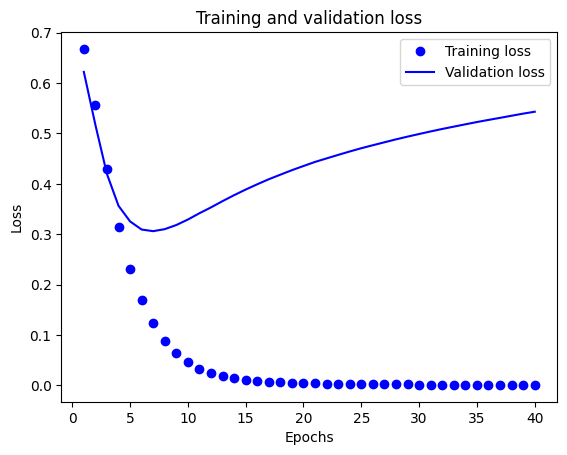

In [15]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

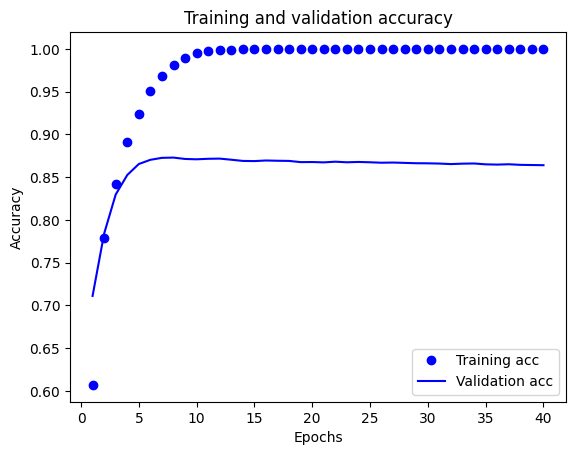

In [16]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

このグラフでは、点はトレーニングの損失と正解度を表し、実線は検証の損失と正解度を表します。

トレーニングの損失がエポックごとに*下降*し、トレーニングの正解度がエポックごとに*上昇*していることに注目してください。これは、勾配下降最適化を使用しているときに見られる現象で、イテレーションごとに希望する量を最小化します。

これは検証の損失と精度には当てはまりません。20 エポック当たりでピークに達しているようです。これが過適合の例で、モデルが、遭遇したことのないデータよりもトレーニングデータで優れたパフォーマンスを発揮する現象です。この後、モデルは過度に最適化し、テストデータに*一般化*しないトレーニングデータ*特有*の表現を学習します。

このような特定のケースについては、約 20 エポック以降のトレーニングを単に停止することで、過適合を回避することができます。この処理をコールバックによって自動的に行う方法については、別の記事で説明します。